## Setup

In [8]:
# !pip uninstall -y tensorflow estimator keras

In [9]:
# !pip install -U tensorflow_text tensorflow tensorflow_datasets

In [10]:
# !pip install einops tensorflow_hub tensorflow_text tensorflow_datasets

In [11]:
import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)


1 Physical GPUs, 1 Logical GPUs


2023-02-10 15:09:19.931490: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-10 15:09:20.019929: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-10 15:09:20.020094: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-10 15:09:20.021565: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorF

In [12]:
#@title
import concurrent.futures
import collections
import dataclasses
import hashlib
import itertools
import json
import math
import os
import pathlib
import random
import re
import string
import time
import urllib.request

import einops
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image
import requests
import tqdm

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
import tensorflow_datasets as tfds

In [13]:
import h5py

size = dict()
steps = dict()
dataset = dict()
path="/home/shashank/Desktop/new trials/CBAM with spatial (copy)/data/iam.hdf5"
with h5py.File(path, "r") as f:
    for pt in ['train','test','valid']:
        dataset[pt] = dict()
        dataset[pt]['dt'] = np.stack([f[pt]['dt'], f[pt]['dt'], f[pt]['dt']], axis=3)
        dataset[pt]['gt'] = np.array(f[pt]['gt'])

        size[pt] = len(dataset[pt]['gt'])
        steps[pt] = int(np.ceil(size[pt] / 16))

In [14]:
dataset['train']['gt']

array([b'A MOVE to stop Mr. Gaitskell from',
       b'nominating any more Labour life Peers',
       b'is to be made at a meeting of Labour', ...,
       b"about it . ' And Philip said : ' But we 've got",
       b"to think about it , don't you see , because",
       b"if we don't it 'll just go on and on , don't"], dtype=object)

In [15]:
dataset['train']['dt'].shape

(6161, 1024, 128, 3)

In [16]:
train_raw= tf.data.Dataset.from_tensor_slices((dataset['train']['dt'], dataset['train']['gt']))
test_raw= tf.data.Dataset.from_tensor_slices((dataset['test']['dt'], dataset['test']['gt']))
valid_raw= tf.data.Dataset.from_tensor_slices((dataset['valid']['dt'], dataset['valid']['gt']))
# ds=dataset

2023-02-10 15:09:34.571005: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 2422603776 exceeds 10% of free system memory.
2023-02-10 15:09:36.012201: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 2422603776 exceeds 10% of free system memory.


In [17]:
train_ds=train_raw
test_ds=test_raw
valid_ds=valid_raw

In [18]:
train_ds.element_spec

(TensorSpec(shape=(1024, 128, 3), dtype=tf.uint8, name=None),
 TensorSpec(shape=(), dtype=tf.string, name=None))

### Image feature extractor

You will use an image model (pretrained on imagenet) to extract the features from each image. The model was trained as an image classifier, but setting `include_top=False` returns the model without the final classification layer, so you can use the last layer of feature-maps:  


Here's a function to load an image and resize it for the model:

In [19]:
IMAGE_SHAPE=(1024, 128, 3)
mobilenet = tf.keras.applications.MobileNetV3Small(
    input_shape=IMAGE_SHAPE,
    include_top=False,
    include_preprocessing=False)
mobilenet.trainable=False

In [20]:
for img, label in test_ds.take(1):
    print(mobilenet(tf.expand_dims(img, axis=0)).shape)
    

2023-02-10 15:09:40.791589: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8400


(1, 32, 4, 576)


2023-02-10 15:09:41.769004: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.


### Setup the text tokenizer/vectorizer

You will transform the text captions into integer sequences using the [TextVectorization](https://www.tensorflow.org/api_docs/python/tf/keras/layers/TextVectorization) layer, with the following steps:

* Use [adapt](https://www.tensorflow.org/api_docs/python/tf/keras/layers/TextVectorization#adapt) to iterate over all captions, split the captions into words, and compute a vocabulary of the top words.
* Tokenize all captions by mapping each word to its index in the vocabulary. All output sequences will be padded to length 50.
* Create word-to-index and index-to-word mappings to display results.

In [21]:
def standardize(s):
  #s = tf.strings.lower(s)
  #s = tf.strings.regex_replace(s, f'[{re.escape(string.punctuation)}]', '')
  s = tf.strings.join(['[START]', s, '[END]'], separator=' ')
  return s

In [23]:
import string

x=string.printable[:95]
len(x)


95

In [24]:
from tensorflow.keras.preprocessing.text import Tokenizer

text_data=string.printable[:95]
print(text_data)

print("char level Tokenizer")

char_tok = Tokenizer(char_level=True)
char_tok.fit_on_texts(text_data)
char_sequences = char_tok.texts_to_sequences(text_data)
print(char_sequences)

char_reconstructed_text = char_tok.sequences_to_texts(char_sequences)
print(char_reconstructed_text)

0123456789abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~ 
char level Tokenizer
[[27], [28], [29], [30], [31], [32], [33], [34], [35], [36], [1], [2], [3], [4], [5], [6], [7], [8], [9], [10], [11], [12], [13], [14], [15], [16], [17], [18], [19], [20], [21], [22], [23], [24], [25], [26], [1], [2], [3], [4], [5], [6], [7], [8], [9], [10], [11], [12], [13], [14], [15], [16], [17], [18], [19], [20], [21], [22], [23], [24], [25], [26], [37], [38], [39], [40], [41], [42], [43], [44], [45], [46], [47], [48], [49], [50], [51], [52], [53], [54], [55], [56], [57], [58], [59], [60], [61], [62], [63], [64], [65], [66], [67], [68], [69]]
['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '!', '"', '#', '$',

In [36]:
#char_tok.fit_on_texts("hello")
char_sequences = char_tok.texts_to_sequences(str(labels))
print(char_sequences)

print(char_tok.sequences_to_texts(char_sequences))

[[59], [2], [43], [1], [69], [13], [15], [22], [5], [69], [20], [15], [69], [19], [20], [15], [16], [69], [13], [18], [50], [69], [7], [1], [9], [20], [19], [11], [5], [12], [12], [69], [6], [18], [15], [13], [43], [], [69], [2], [43], [14], [15], [13], [9], [14], [1], [20], [9], [14], [7], [69], [1], [14], [25], [69], [13], [15], [18], [5], [69], [12], [1], [2], [15], [21], [18], [69], [12], [9], [6], [5], [69], [16], [5], [5], [18], [19], [43], [], [69], [2], [43], [9], [19], [69], [20], [15], [69], [2], [5], [69], [13], [1], [4], [5], [69], [1], [20], [69], [1], [69], [13], [5], [5], [20], [9], [14], [7], [69], [15], [6], [69], [12], [1], [2], [15], [21], [18], [43], [69], [50], [50], [50], [], [69], [2], [38], [1], [2], [15], [21], [20], [69], [9], [20], [69], [50], [69], [43], [69], [1], [14], [4], [69], [16], [8], [9], [12], [9], [16], [69], [19], [1], [9], [4], [69], [52], [69], [43], [69], [2], [21], [20], [69], [23], [5], [69], [43], [22], [5], [69], [7], [15], [20], [38], [],

In [28]:
# # Use the top 5000 words for a vocabulary.
# from tf.keras.preprocessing.text import Tokenizer
# vocabulary_size = 5000
# tokenizer = Tokenizer(
#     max_tokens=vocabulary_size,
#     standardize=standardize,
#     output_sequence_length=30,
#     pad_to_max_tokens= True
# #     ragged=True
# )
# # Learn the vocabulary from the caption data.

In [19]:
# # Use the top 5000 words for a vocabulary.
# from tensorflow.keras.preprocessing.text import Tokenizer
# #vocabulary_size = 98
# tokenizer = Tokenizer(
#     num_words=98, char_level=True
# )
# # Learn the vocabulary from the caption data.

In [29]:
tokenizer.fit_on_texts(labels) 

NameError: name 'tokenizer' is not defined

In [33]:
labels=dataset['train']['gt']

In [34]:
labels

array([b'A MOVE to stop Mr. Gaitskell from',
       b'nominating any more Labour life Peers',
       b'is to be made at a meeting of Labour', ...,
       b"about it . ' And Philip said : ' But we 've got",
       b"to think about it , don't you see , because",
       b"if we don't it 'll just go on and on , don't"], dtype=object)

In [22]:
# labels= np.concatenate(dataset['train']['gt'], dataset['test']['gt'])
# labels= np.concatenate(labels, dataset['valid']['gt'])

In [37]:
labels.shape

(6161,)

In [24]:
# tokenizer.adapt(train_raw.map(lambda fp,txt: txt).unbatch().batch(1024))
tokenizer.adapt(labels)

AttributeError: 'Tokenizer' object has no attribute 'adapt'

In [36]:
tokenizer.get_vocabulary()[:10]

AttributeError: 'Tokenizer' object has no attribute 'get_vocabulary'

In [29]:
t = tokenizer([['a cat in a hat'], ['a robot dog']])
t

TypeError: 'Tokenizer' object is not callable

In [32]:
# Create mappings for words to indices and indices to words.
word_to_index = tf.keras.layers.StringLookup(
    mask_token="",
    vocabulary=tokenizer.get_vocabulary())
index_to_word = tf.keras.layers.StringLookup(
    mask_token="",
    vocabulary=tokenizer.get_vocabulary(),
    invert=True)

AttributeError: 'Tokenizer' object has no attribute 'get_vocabulary'

In [31]:
w = index_to_word(t)
# w.to_list()

NameError: name 'index_to_word' is not defined

In [30]:
tf.strings.reduce_join(w, separator=' ', axis=-1).numpy()

NameError: name 'w' is not defined

### Prepare the datasets

The `train_raw` and `test_raw` datasets contain 1:many `(image, captions)` pairs. 

This function will replicate the image so there are 1:1 images to captions:

In [24]:
for images, labels in test_ds.batch(32).take(1):
  break

print('images:', images.shape)
print('labels:', labels.shape)
print()


images: (32, 1024, 128, 3)
labels: (32,)



To be compatible with keras training the dataset should contain `(inputs, labels)` pairs. For text generation the tokens are both an input and the labels, shifted by one step. This function will convert an `(images, texts)` pair to an `((images, input_tokens), label_tokens)` pair:

In [25]:
def prepare_txt(imgs, txts):
  tokens = tokenizer(txts)

  input_tokens = tokens[..., :-1]
  label_tokens = tokens[..., 1:]
  return (imgs, input_tokens), label_tokens

This function adds operations to a dataset. The steps are:

1. Load the images (and ignore images that fail to load).
2. Replicate images to match the number of captions.
3. Shuffle and rebatch the `image, caption` pairs.
4. Tokenize the text, shift the tokens and add `label_tokens`.
5. Convert the text from a `RaggedTensor` representation to padded dense `Tensor` representation.

In [26]:
def prepare_dataset(ds, tokenizer, batch_size=32, shuffle_buffer=1000):
  # Load the images and make batches.
  ds = (ds
        .shuffle(1000)
        .apply(tf.data.experimental.ignore_errors())
        .batch(batch_size))

  def to_tensor(inputs, labels):
    (images, in_tok), out_tok = inputs, labels
    return (images, in_tok), out_tok

  return (ds
          .unbatch()
          .shuffle(shuffle_buffer)
          .batch(batch_size)
          .map(prepare_txt, tf.data.AUTOTUNE)
          .map(to_tensor, tf.data.AUTOTUNE)
          )

You could install the feature extractor in your model and train on the datasets like this:

In [27]:
# train_ds = prepare_dataset(train_ds, tokenizer)
# train_ds.element_spec

In [28]:
# test_ds = prepare_dataset(test_ds, tokenizer)
# test_ds.element_spec

In [29]:
# valid_ds = prepare_dataset(valid_ds, tokenizer)
# valid_ds.element_spec

### [Optional] Cache the image features

Since the image feature extractor is not changing, and this tutorial is not using image augmentation, the image features can be cached. Same for the text tokenization. The time it takes to set up the cache is earned back on each epoch during training and validation. The code below defines two functions `save_dataset` and `load_dataset`: 

In [30]:
tem_ds = (train_ds
        .apply(tf.data.experimental.ignore_errors()))

Instructions for updating:
Use `tf.data.Dataset.ignore_errors` instead.


In [31]:
tem_ds.element_spec

(TensorSpec(shape=(1024, 128, 3), dtype=tf.uint8, name=None),
 TensorSpec(shape=(), dtype=tf.string, name=None))

In [32]:
def save_dataset(ds, save_path, image_model, tokenizer, shards=10, batch_size=32):
  # Load the images and make batches.
  ds = (ds
        .apply(tf.data.experimental.ignore_errors())
        .batch(batch_size))

  # Run the feature extractor on each batch
  # Don't do this in a .map, because tf.data runs on the CPU. 
  def gen():
    for (images, captions) in tqdm.tqdm(ds): 
      feature_maps = image_model(images)
      yield feature_maps, captions

  # Wrap the generator in a new tf.data.Dataset.
  new_ds = tf.data.Dataset.from_generator(
      gen,
      output_signature=(
          tf.TensorSpec(shape=image_model.output_shape),
          tf.TensorSpec(shape=(None,), dtype=tf.string)))

  # Apply the tokenization 
  new_ds = (new_ds
            .map(prepare_txt, tf.data.AUTOTUNE)
            .unbatch()
            .shuffle(1000))

  # Save the dataset into shard files.
  def shard_func(i, item):
    return i % shards
  new_ds.enumerate().save(save_path, shard_func=shard_func)

def load_dataset(save_path, batch_size=32, shuffle=1000, cycle_length=2):
  def custom_reader_func(datasets):
    datasets = datasets.shuffle(1000)
    return datasets.interleave(lambda x: x, cycle_length=cycle_length)
  
  ds = tf.data.Dataset.load(save_path, reader_func=custom_reader_func)

  def drop_index(i, x):
    return x

  ds = (ds
        .map(drop_index, tf.data.AUTOTUNE)
        .shuffle(shuffle)
        .padded_batch(batch_size)
        .prefetch(tf.data.AUTOTUNE))
  return ds

In [33]:
save_dataset(train_ds, 'train_cache', mobilenet, tokenizer)

2023-02-06 17:47:29.941432: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
0it [00:00, ?it/s]2023-02-06 17:47:29.999113: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 2422603776 exceeds 10% of free system memory.
193it [00:11, 16.34it/s]


In [34]:
save_dataset(test_ds, 'test_cache', mobilenet, tokenizer)

2023-02-06 17:47:47.354049: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
59it [00:03, 16.52it/s]


In [35]:
save_dataset(valid_ds, 'valid_cache', mobilenet, tokenizer)

2023-02-06 17:47:51.074863: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
58it [00:03, 16.48it/s]


 </section>


## Data ready for training

After those preprocessing steps, here are the datasets:

In [36]:
train_ds = load_dataset('train_cache')
test_ds = load_dataset('test_cache')
valid_ds = load_dataset('valid_cache')

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [37]:
train_ds.element_spec

((TensorSpec(shape=(None, 32, 4, 576), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 29), dtype=tf.int64, name=None)),
 TensorSpec(shape=(None, 29), dtype=tf.int64, name=None))

The dataset now returns `(input, label)` pairs suitable for training with keras. The `inputs` are `(images, input_tokens)` pairs. The `images` have been processed with the feature-extractor model. For each location in the `input_tokens` the model looks at the text so far and tries to predict the next which is lined up at the same location in the `labels`.

In [38]:
for (inputs, ex_labels) in train_ds.take(1):
    (ex_img, ex_in_tok) = inputs

print(ex_img.shape)
print(ex_in_tok.shape)
print(ex_labels.shape)

(32, 32, 4, 576)
(32, 29)
(32, 29)


The input tokens and the labels are the same, just shifted by 1 step:

In [39]:
# print(ex_in_tok[0].numpy())
print(ex_labels[0].numpy())

[ 638   19    7 3042  124    1    3    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0]


## A Transformer decoder model

This model assumes that the pretrained image encoder is sufficient, and just focuses on building the text decoder. This tutorial uses a 2-layer Transformer-decoder.

The implementations are almost identical to those in the [Transformers tutorial](https://www.tensorflow.org/text/tutorials/transformer). Refer back to it for more details.

<table>
<tr>
  <th>The Transformer encoder and decoder.</th>
</tr>
<tr>
  <td>
   <img width=400 src="https://www.tensorflow.org/images/tutorials/transformer/Transformer-1layer-words.png"/>
  </td>
</tr>
</table>

The model will be implemented in three main parts: 

1. Input - The token embedding and positional encoding (`SeqEmbedding`).
1. Decoder - A stack of transformer decoder layers (`DecoderLayer`) where each contains:
   1. A causal self attention later (`CausalSelfAttention`), where each output location can attend to the output so far.
   1. A cross attention layer (`CrossAttention`) where each output location can attend to the input image.
   1. A feed forward network (`FeedForward`) layer which further processes each output location independently.
1. Output - A multiclass-classification over the output vocabulary.


### Input

The input text has already been split up into tokens and converted to sequences of IDs. 

Remember that unlike a CNN or RNN the Transformer's attention layers are invariant to the order of the sequence. Without some positional input, it just sees an unordered set not a sequence. So in addition to a simple vector embedding for each token ID, the embedding layer will also include an embedding for each position in the sequence.

The `SeqEmbedding` layer defined below:

- It looks up the embedding vector for each token.
- It looks up an embedding vector for each sequence location.
- It adds the two together.
- It uses `mask_zero=True` to initialize the keras-masks for the model.

Note: This implementation learns the position embeddings instead of using fixed embeddings like in the [Transformer tutorial](https://www.tensorflow.org/text/tutorials/transformer). Learning the embeddings is slightly less code, but doesn't generalize to longer sequences.

In [40]:
class SeqEmbedding(tf.keras.layers.Layer):
  def __init__(self, vocab_size, max_length, depth):
    super().__init__()
    self.pos_embedding = tf.keras.layers.Embedding(input_dim=max_length, output_dim=depth)

    self.token_embedding = tf.keras.layers.Embedding(
        input_dim=vocab_size,
        output_dim=depth,
        mask_zero=True)
    
    self.add = tf.keras.layers.Add()

  def call(self, seq):
    seq = self.token_embedding(seq) # (batch, seq, depth)

    x = tf.range(tf.shape(seq)[1])  # (seq)
    x = x[tf.newaxis, :]  # (1, seq)
    x = self.pos_embedding(x)  # (1, seq, depth)

    return self.add([seq,x])

### Decoder

The decoder is a standard Transformer-decoder, it contains a stack of `DecoderLayers` where each contains three sublayers: a `CausalSelfAttention`, a `CrossAttention`, and a`FeedForward`. The implementations are almost identical to the [Transformer tutorial](https://www.tensorflow.org/text/tutorials/transformer), refer to it for more details.

The `CausalSelfAttention` layer is below:

In [41]:
class CausalSelfAttention(tf.keras.layers.Layer):
  def __init__(self, **kwargs):
    super().__init__()
    self.mha = tf.keras.layers.MultiHeadAttention(**kwargs)
    # Use Add instead of + so the keras mask propagates through.
    self.add = tf.keras.layers.Add() 
    self.layernorm = tf.keras.layers.LayerNormalization()
  
  def call(self, x):
    attn = self.mha(query=x, value=x,
                    use_causal_mask=True)
    x = self.add([x, attn])
    return self.layernorm(x)


The `CrossAttention` layer is below. Note the use of `return_attention_scores`.

In [42]:
class CrossAttention(tf.keras.layers.Layer):
  def __init__(self,**kwargs):
    super().__init__()
    self.mha = tf.keras.layers.MultiHeadAttention(**kwargs)
    self.add = tf.keras.layers.Add() 
    self.layernorm = tf.keras.layers.LayerNormalization()
  
  def call(self, x, y, **kwargs):
    attn, attention_scores = self.mha(
             query=x, value=y,
             return_attention_scores=True)
    
    self.last_attention_scores = attention_scores

    x = self.add([x, attn])
    return self.layernorm(x)

The `FeedForward` layer is below. Remember that a `layers.Dense` layer is applied to the last axis of the input. The input will have a shape of `(batch, sequence, channels)`, so it automatically applies pointwise across the `batch` and `sequence` axes.  

In [43]:
class FeedForward(tf.keras.layers.Layer):
  def __init__(self, units, dropout_rate=0.1):
    super().__init__()
    self.seq = tf.keras.Sequential([
        tf.keras.layers.Dense(units=2*units, activation='relu'),
        tf.keras.layers.Dense(units=units),
        tf.keras.layers.Dropout(rate=dropout_rate),
    ])

    self.layernorm = tf.keras.layers.LayerNormalization()
  
  def call(self, x):
    x = x + self.seq(x)
    return self.layernorm(x)


Next arrange these three layers into a larger `DecoderLayer`. Each decoder layer applies the three smaller layers in sequence. After each sublayer the shape of `out_seq` is `(batch, sequence, channels)`. The decoder layer also returns the `attention_scores` for later visualizations.

In [44]:
class DecoderLayer(tf.keras.layers.Layer):
  def __init__(self, units, num_heads=1, dropout_rate=0.1):
    super().__init__()
    
    self.self_attention = CausalSelfAttention(num_heads=num_heads,
                                              key_dim=units,
                                              dropout=dropout_rate)
    self.cross_attention = CrossAttention(num_heads=num_heads,
                                          key_dim=units,
                                          dropout=dropout_rate)
    self.ff = FeedForward(units=units, dropout_rate=dropout_rate)
      

  def call(self, inputs, training=False):
    in_seq, out_seq = inputs

    # Text input
    out_seq = self.self_attention(out_seq)

    out_seq = self.cross_attention(out_seq, in_seq)
    
    self.last_attention_scores = self.cross_attention.last_attention_scores

    out_seq = self.ff(out_seq)

    return out_seq

### Output

At minimum the output layer needs a `layers.Dense` layer to generate logit-predictions for each token at each location.

But there are a few other features you can add to make this work a little better:

1. **Handle bad tokens**: The model will be generating text. It should
   never generate a pad, unknown, or start token (`''`, `'[UNK]'`, 
   `'[START]'`). So set the bias for these to a large negative value.

   > Note: You'll need to ignore these tokens in the loss function as well. 

2. **Smart initialization**: The default initialization of a dense layer will
  give a model that initially predicts each token with almost uniform
  likelihood. The actual token distribution is far from uniform. The
  optimal value for the initial bias of the output layer is the log of the
  probability of each token. So include an `adapt` method to count the tokens
  and set the optimal initial bias. This reduces the initial loss from the
  entropy of the uniform distribution (`log(vocabulary_size)`) to the marginal
  entropy of the distribution (`-p*log(p)`).


In [45]:
#@title
class TokenOutput(tf.keras.layers.Layer):
  def __init__(self, tokenizer, banned_tokens=('', '[UNK]', '[START]'), **kwargs):
    super().__init__()
    
    self.dense = tf.keras.layers.Dense(
        units=tokenizer.vocabulary_size(), **kwargs)
    self.tokenizer = tokenizer
    self.banned_tokens = banned_tokens

    self.bias = None

  def adapt(self, ds):
    counts = collections.Counter()
    vocab_dict = {name: id 
                  for id, name in enumerate(self.tokenizer.get_vocabulary())}

    for tokens in tqdm.tqdm(ds):
      counts.update(tokens.numpy().flatten())

    counts_arr = np.zeros(shape=(self.tokenizer.vocabulary_size(),))
    counts_arr[np.array(list(counts.keys()), dtype=np.int32)] = list(counts.values())

    counts_arr = counts_arr[:]
    for token in self.banned_tokens:
      counts_arr[vocab_dict[token]] = 0

    total = counts_arr.sum()
    p = counts_arr/total
    p[counts_arr==0] = 1.0
    log_p = np.log(p)  # log(1) == 0

    entropy = -(log_p*p).sum()

    print()
    print(f"Uniform entropy: {np.log(self.tokenizer.vocabulary_size()):0.2f}")
    print(f"Marginal entropy: {entropy:0.2f}")

    self.bias = log_p
    self.bias[counts_arr==0] = -1e9

  def call(self, x):
    x = self.dense(x)
    # TODO(b/250038731): Fix this.
    # An Add layer doesn't work because of the different shapes.
    # This clears the mask, that's okay because it prevents keras from rescaling
    # the losses.
    return x + self.bias


The smart initialization will significantly reduce the initial loss:

In [46]:
output_layer = TokenOutput(tokenizer, banned_tokens=('', '[UNK]', '[START]'))
# This might run a little faster if the dataset didn't also have to load the image data.
output_layer.adapt(train_ds.map(lambda inputs, labels: labels))

100%|████████████████████████████████████████| 193/193 [00:00<00:00, 214.99it/s]


Uniform entropy: 8.52
Marginal entropy: 6.12


### Build the model

To build the model, you need to combine several parts:

1. The image `feature_extractor` and the text `tokenizer` and.
1. The `seq_embedding` layer, to convert batches of token-IDs to 
   vectors `(batch, sequence, channels)`.
3. The stack of `DecoderLayers` layers that will process the text and image data.
4. The `output_layer` which returns a pointwise prediction of what the next word should be.

In [47]:
class Captioner(tf.keras.Model):
  @classmethod
  def add_method(cls, fun):
    setattr(cls, fun.__name__, fun)
    return fun

  def __init__(self, tokenizer, feature_extractor, output_layer, num_layers=1,
               units=256, max_length=50, num_heads=1, dropout_rate=0.1):
    super().__init__()
    self.feature_extractor = feature_extractor
    self.tokenizer = tokenizer
    self.word_to_index = tf.keras.layers.StringLookup(
        mask_token="",
        vocabulary=tokenizer.get_vocabulary())
    self.index_to_word = tf.keras.layers.StringLookup(
        mask_token="",
        vocabulary=tokenizer.get_vocabulary(),
        invert=True) 

    self.seq_embedding = SeqEmbedding(
        vocab_size=tokenizer.vocabulary_size(),
        depth=units,
        max_length=max_length)

    self.decoder_layers = [
        DecoderLayer(units, num_heads=num_heads, dropout_rate=dropout_rate)
        for n in range(num_layers)]

    self.output_layer = output_layer

When you call the model, for training, it receives an `image, txt` pair. To make this function more usable, be flexible about the input:

* If the image has 3 channels run it through the feature_extractor. Otherwise assume that it has been already. Similarly
* If the text has dtype `tf.string` run it through the tokenizer.

After that running the model is only a few steps:

1. Flatten the extracted image features, so they can be input to the decoder layers.
2. Look up the token embeddings.
3. Run the stack of `DecoderLayer`s, on the image features and text embeddings.
4. Run the output layer to predict the next token at each position.


In [48]:
  @Captioner.add_method
  def call(self, inputs):
    image, txt = inputs

    if image.shape[-1] == 3:
      # Apply the feature-extractor, if you get an RGB image.
      image = self.feature_extractor(image)
    
    # Flatten the feature map
    image = einops.rearrange(image, 'b h w c -> b (h w) c')


    if txt.dtype == tf.string:
      # Apply the tokenizer if you get string inputs.
      txt = tokenizer(txt)

    txt = self.seq_embedding(txt)

    # Look at the image
    for dec_layer in self.decoder_layers:
      txt = dec_layer(inputs=(image, txt))
      
    txt = self.output_layer(txt)

    return txt

In [49]:
model = Captioner(tokenizer, feature_extractor=mobilenet, output_layer=output_layer,
                  units=256, dropout_rate=0.5, num_layers=2, num_heads=2)

### Generate captions

Before getting into training, write a bit of code to generate captions. You'll use this to see how training is progressing.

Start by downloading a test image:

In [82]:
for img, label in test_ds.take(1):
    break

In [87]:
w = index_to_word(label[0])
print(w)

tf.Tensor(
[b'[UNK]' b'[UNK]' b'said' b'[UNK]' b'smiling' b'from' b'the' b'bottom'
 b'step' b'[END]' b'' b'' b'' b'' b'' b'' b'' b'' b'' b'' b'' b'' b'' b''
 b'' b'' b'' b'' b''], shape=(29,), dtype=string)


In [84]:
img[0][0]

<tf.Tensor: shape=(32, 4, 576), dtype=float32, numpy=
array([[[  -0.    ,   -0.    ,   -0.    , ...,   -0.    ,   -0.    ,
           -0.    ],
        [  -0.    ,   -0.    ,   -0.    , ...,   -0.    ,   -0.    ,
           -0.    ],
        [  -0.    ,   -0.    ,   -0.    , ...,   -0.    ,   -0.    ,
           -0.    ],
        [  -0.    ,   -0.    ,   -0.    , ...,   -0.    ,   -0.    ,
           -0.    ]],

       [[  -0.    ,   -0.    ,   -0.    , ...,   -0.    ,   -0.    ,
           -0.    ],
        [  -0.    , 7949.9277,   -0.    , ...,   -0.    ,   -0.    ,
           -0.    ],
        [  -0.    ,   -0.    ,   -0.    , ...,   -0.    ,   -0.    ,
           -0.    ],
        [  -0.    , 5098.855 ,   -0.    , ...,   -0.    ,   -0.    ,
           -0.    ]],

       [[  -0.    , 1254.3976,   -0.    , ...,   -0.    ,   -0.    ,
           -0.    ],
        [  -0.    , 2324.9558,   -0.    , ...,   -0.    ,   -0.    ,
           -0.    ],
        [  -0.    ,   -0.    ,   -0.    , 

To caption an image with this model:

- Extract the `img_features`
- Initialize the list of output tokens with a `[START]` token.
- Pass `img_features` and `tokens` into the model.
  - It returns a list of logits.
  - Choose the next token based on those logits.  
  - Add it to the list of tokens, and continue the loop.
  - If it generates an `'[END]'` token, break out of the loop.

So add a "simple" method to do just that:

In [70]:
@Captioner.add_method
def simple_gen(self, image, temperature=1):
  initial = self.word_to_index([['[START]']]) # (batch, sequence)
  img_features = tf.expand_dims(image, axis=0)
#   img_features = self.feature_extractor(image[tf.newaxis, ...])

  tokens = initial # (batch, sequence)
  for n in range(50):
    preds = self((img_features, tokens)).numpy()  # (batch, sequence, vocab)
    preds = preds[:,-1, :]  #(batch, vocab)
    if temperature==0:
        next = tf.argmax(preds, axis=-1)[:, tf.newaxis]  # (batch, 1)
    else:
        next = tf.random.categorical(preds/temperature, num_samples=1)  # (batch, 1)
    tokens = tf.concat([tokens, next], axis=1) # (batch, sequence) 

    if next[0] == self.word_to_index('[END]'):
      break
  words = index_to_word(tokens[0, 1:-1])
  result = tf.strings.reduce_join(words, axis=-1, separator=' ')
  return result.numpy().decode()

Here are some generated captions for that image, the model's untrained, so they don't make much sense yet:

In [71]:
for t in (0.0, 0.5, 1.0):
  result = model.simple_gen(img[0][0], temperature=t)
  print(result)


the the a the the the
set by again colonial sedate fear like width parks spite you a


The temperature parameter allows you to interpolate between 3 modes:

1. Greedy decoding (`temperature=0.0`) - Chooses the most likely next token at each step.
2. Random sampling according to the logits (`temperature=1.0`).
3. Uniform random sampling (`temperature >> 1.0`). 

Since the model is untrained, and it used the frequency-based initialization, the "greedy" output (first) usually only contains the most common tokens: `['a', '.', '[END]']`.

## Train

To train the model you'll need several additional components:

- The Loss and metrics
- The Optimizer
- Optional Callbacks

### Losses and metrics

Here's an implementation of a masked loss and accuracy:

When calculating the mask for the loss, note the `loss < 1e8`. This term discards the artificial, impossibly high losses for the `banned_tokens`.

In [72]:
def masked_loss(labels, preds):  
  loss = tf.nn.sparse_softmax_cross_entropy_with_logits(labels, preds)

  mask = (labels != 0) & (loss < 1e8) 
  mask = tf.cast(mask, loss.dtype)

  loss = loss*mask
  loss = tf.reduce_sum(loss)/tf.reduce_sum(mask)
  return loss

def masked_acc(labels, preds):
  mask = tf.cast(labels!=0, tf.float32)
  preds = tf.argmax(preds, axis=-1)
  labels = tf.cast(labels, tf.int64)
  match = tf.cast(preds == labels, mask.dtype)
  acc = tf.reduce_sum(match*mask)/tf.reduce_sum(mask)
  return acc

### Callbacks

For feedback during training setup a `keras.callbacks.Callback` to generate some captions for the surfer image at the end of each epoch.

In [73]:
class GenerateText(tf.keras.callbacks.Callback):
  def __init__(self):
    self.image=img[0][0]
    

  def on_epoch_end(self, epochs=None, logs=None):
    print()
    print()
    for t in (0.0, 0.5, 1.0):
      result = self.model.simple_gen(self.image, temperature=t)
      print(result)
    print()


It generates three output strings, like the earlier example, like before the first is "greedy", choosing the argmax of the logits at each step.

In [74]:
g = GenerateText()
g.model = model
g.on_epoch_end(0)





one way edward



Also use `callbacks.EarlyStopping` to terminate training when the model starts to overfit.

In [75]:
callbacks = [
    GenerateText(),
    tf.keras.callbacks.EarlyStopping(
        patience=5, restore_best_weights=True)]

### Train

Configure and execute the training.

In [76]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
           loss=masked_loss,
           metrics=[masked_acc])

For more frequent reporting, use the `Dataset.repeat()` method, and set the `steps_per_epoch` and `validation_steps` arguments to `Model.fit`. 

With this setup on `Flickr8k` a full pass over the dataset is 900+ batches, but below the reporting-epochs are 100 steps.

In [77]:
history = model.fit(
    train_ds.repeat(),
    steps_per_epoch=100,
    validation_data=valid_ds.repeat(),
    validation_steps=20,
    epochs=100,
    callbacks=callbacks)

Epoch 1/100


2023-02-06 17:57:46.056495: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x55615eff28b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-02-06 17:57:46.056513: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA GeForce RTX 2080 Ti, Compute Capability 7.5
2023-02-06 17:57:46.084298: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-02-06 17:57:46.323183: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.
2023-02-06 17:57:46.358118: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cl

  1/100 [..............................] - ETA: 13:12 - loss: 6.3798 - masked_acc: 0.1136

2023-02-06 17:57:49.548087: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.
2023-02-06 17:57:49.654136: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.


  3/100 [..............................] - ETA: 12s - loss: 6.2430 - masked_acc: 0.1174 

2023-02-06 17:57:49.791489: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.
2023-02-06 17:57:49.921590: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.


  6/100 [>.............................] - ETA: 10s - loss: 6.2145 - masked_acc: 0.1143

2023-02-06 17:57:50.081423: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.
2023-02-06 17:57:50.212341: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.


  8/100 [=>............................] - ETA: 10s - loss: 6.1984 - masked_acc: 0.1138

2023-02-06 17:57:50.340393: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.
2023-02-06 17:57:50.469905: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.


 10/100 [==>...........................] - ETA: 10s - loss: 6.1691 - masked_acc: 0.1131

2023-02-06 17:57:50.597591: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.
2023-02-06 17:57:50.733022: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.


 13/100 [==>...........................] - ETA: 9s - loss: 6.1754 - masked_acc: 0.1125 

2023-02-06 17:57:50.918754: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.
2023-02-06 17:57:51.078114: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.


 18/100 [====>.........................] - ETA: 8s - loss: 6.1841 - masked_acc: 0.1134

2023-02-06 17:57:51.214252: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.
2023-02-06 17:57:51.363371: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.


 20/100 [=====>........................] - ETA: 8s - loss: 6.1770 - masked_acc: 0.1141

2023-02-06 17:57:51.495137: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.
2023-02-06 17:57:51.619841: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.


 24/100 [======>.......................] - ETA: 7s - loss: 6.1619 - masked_acc: 0.1150

2023-02-06 17:57:51.775809: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.
2023-02-06 17:57:51.923501: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.


 26/100 [======>.......................] - ETA: 7s - loss: 6.1719 - masked_acc: 0.1152

2023-02-06 17:57:52.077003: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.
2023-02-06 17:57:52.209550: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.


 29/100 [=======>......................] - ETA: 7s - loss: 6.1788 - masked_acc: 0.1152

2023-02-06 17:57:52.333542: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.
2023-02-06 17:57:52.479648: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.


 33/100 [========>.....................] - ETA: 6s - loss: 6.1773 - masked_acc: 0.1152

2023-02-06 17:57:52.649823: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.
2023-02-06 17:57:52.776256: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.


 46/100 [============>.................] - ETA: 4s - loss: 6.1735 - masked_acc: 0.1150

2023-02-06 17:57:53.163345: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.
2023-02-06 17:57:53.297629: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.


 56/100 [===============>..............] - ETA: 3s - loss: 6.1702 - masked_acc: 0.1148

2023-02-06 17:57:53.484613: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.


 71/100 [====================>.........] - ETA: 1s - loss: 6.1774 - masked_acc: 0.1148

2023-02-06 17:57:53.907139: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.


 99/100 [============================>.] - ETA: 0s - loss: 6.1760 - masked_acc: 0.1148

2023-02-06 17:57:54.788945: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.






of

100/100 [==============================] - 15s 67ms/step - loss: 6.1748 - masked_acc: 0.1147 - val_loss: 5.7214 - val_masked_acc: 0.1119
Epoch 2/100
 16/100 [===>..........................] - ETA: 2s - loss: 6.1712 - masked_acc: 0.1152

2023-02-06 17:57:56.573117: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.


 30/100 [========>.....................] - ETA: 1s - loss: 6.1534 - masked_acc: 0.1151

2023-02-06 17:57:56.970999: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.


 40/100 [===========>..................] - ETA: 1s - loss: 6.1580 - masked_acc: 0.1146

2023-02-06 17:57:57.300818: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.


 48/100 [=============>................] - ETA: 1s - loss: 6.1654 - masked_acc: 0.1147

2023-02-06 17:57:57.569864: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.


 85/100 [========================>.....] - ETA: 0s - loss: 6.1580 - masked_acc: 0.1141

2023-02-06 17:57:58.437652: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.


 91/100 [==========================>...] - ETA: 0s - loss: 6.1606 - masked_acc: 0.1139

2023-02-06 17:57:58.766488: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.


 96/100 [===========================>..] - ETA: 0s - loss: 6.1618 - masked_acc: 0.1140

2023-02-06 17:57:58.973277: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.


 98/100 [============================>.] - ETA: 0s - loss: 6.1592 - masked_acc: 0.1138

2023-02-06 17:57:59.185505: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.






but understanding by master the effective a national which in

100/100 [==============================] - 4s 40ms/step - loss: 6.1602 - masked_acc: 0.1139 - val_loss: 5.6848 - val_masked_acc: 0.1132
Epoch 3/100
 25/100 [======>.......................] - ETA: 1s - loss: 6.1430 - masked_acc: 0.1165

2023-02-06 17:58:00.798069: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.


 33/100 [========>.....................] - ETA: 1s - loss: 6.1391 - masked_acc: 0.1163

2023-02-06 17:58:01.069918: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.


 54/100 [===============>..............] - ETA: 1s - loss: 6.1342 - masked_acc: 0.1153

2023-02-06 17:58:01.613488: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.


 99/100 [============================>.] - ETA: 0s - loss: 6.1521 - masked_acc: 0.1143

2023-02-06 17:58:02.772437: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.






the lloyd he normal performance may

100/100 [==============================] - 3s 34ms/step - loss: 6.1547 - masked_acc: 0.1143 - val_loss: 5.6369 - val_masked_acc: 0.1114
Epoch 4/100
 42/100 [===========>..................] - ETA: 1s - loss: 6.1413 - masked_acc: 0.1156

2023-02-06 17:58:04.508291: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.


 55/100 [===============>..............] - ETA: 1s - loss: 6.1360 - masked_acc: 0.1153

2023-02-06 17:58:04.906531: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.


 80/100 [=======================>......] - ETA: 0s - loss: 6.1289 - masked_acc: 0.1148

2023-02-06 17:58:05.653737: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.
2023-02-06 17:58:05.820795: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.


 91/100 [==========================>...] - ETA: 0s - loss: 6.1377 - masked_acc: 0.1144

2023-02-06 17:58:06.041213: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.


100/100 [==============================] - ETA: 0s - loss: 6.1305 - masked_acc: 0.1146


and
by homoeopathy fast disaster

100/100 [==============================] - 3s 35ms/step - loss: 6.1305 - masked_acc: 0.1146 - val_loss: 5.6614 - val_masked_acc: 0.1108
Epoch 5/100
 77/100 [======================>.......] - ETA: 0s - loss: 6.1281 - masked_acc: 0.1159

2023-02-06 17:58:08.779062: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.


 98/100 [============================>.] - ETA: 0s - loss: 6.1382 - masked_acc: 0.1161



the a

100/100 [==============================] - 3s 30ms/step - loss: 6.1383 - masked_acc: 0.1162 - val_loss: 5.6748 - val_masked_acc: 0.1120
Epoch 6/100
 54/100 [===============>..............] - ETA: 1s - loss: 6.1256 - masked_acc: 0.1144

2023-02-06 17:58:11.250799: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.


 85/100 [========================>.....] - ETA: 0s - loss: 6.1315 - masked_acc: 0.1147

2023-02-06 17:58:12.030928: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.


100/100 [==============================] - ETA: 0s - loss: 6.1334 - masked_acc: 0.1152


the
but is production point press dingy standards with de foreign

100/100 [==============================] - 3s 34ms/step - loss: 6.1334 - masked_acc: 0.1152 - val_loss: 5.6381 - val_masked_acc: 0.1109
Epoch 7/100
 64/100 [==================>...........] - ETA: 0s - loss: 6.1313 - masked_acc: 0.1163

2023-02-06 17:58:14.782003: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.


100/100 [==============================] - ETA: 0s - loss: 6.1244 - masked_acc: 0.1158



in of her

100/100 [==============================] - 3s 28ms/step - loss: 6.1244 - masked_acc: 0.1158 - val_loss: 5.6813 - val_masked_acc: 0.1124
Epoch 8/100
 78/100 [======================>.......] - ETA: 0s - loss: 6.0882 - masked_acc: 0.1151

2023-02-06 17:58:17.933515: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.


 99/100 [============================>.] - ETA: 0s - loss: 6.0967 - masked_acc: 0.1155



delay is known for dropped diplomatist get government government sixtyfour assumption project the and is to are

100/100 [==============================] - 4s 36ms/step - loss: 6.0951 - masked_acc: 0.1155 - val_loss: 5.7056 - val_masked_acc: 0.1119


Plot the loss and accuracy over the training run:

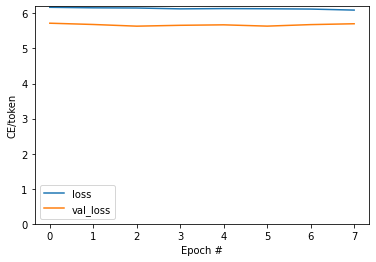

In [78]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch #')
plt.ylabel('CE/token')
plt.legend()

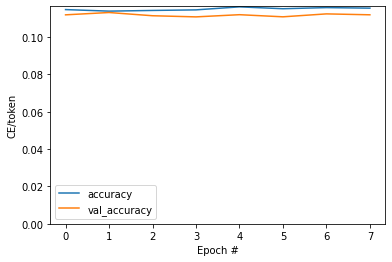

In [79]:
plt.plot(history.history['masked_acc'], label='accuracy')
plt.plot(history.history['val_masked_acc'], label='val_accuracy')
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch #')
plt.ylabel('CE/token')
plt.legend()

In [ ]:
image_url = 'https://tensorflow.org/images/bedroom_hrnet_tutorial.jpg'
image_path = tf.keras.utils.get_file(origin=image_url)
image = load_image(image_path)

run_and_show_attention(model, image)